## Module 5 Project

In [2]:
# import packages and keep plots within cells
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

#### 1. Split the data into a 70-30 split for training and testing data.

In [3]:
# open RADAR parameters dataset
df = pd.read_csv('homework/radar_parameters.csv', 
                  usecols=[i for i in range(1, 8)])

# compute Z from given unit conversion from DBZ
df['Z'] = 10**(df['Zh (dBZ)'] / 10)
# move Z column to first position
col = df.pop("Z")
df.insert(0, col.name, col)

# separate features (not including Z for baseline model) and target variable
feats = df.iloc[:, range(1, 7)]
target = df.iloc[:, 7]

In [15]:
# split the data for 70% training dataset
x_train, x_test, y_train, y_test_again = train_test_split(
    feats, target, random_state=0, train_size=0.7)
# print row counts to confirm 70-30 split
print('Training and Testing Row Counts: ')
print(x_train.shape[0], x_test.shape[0], sep=', ')

Training and Testing Row Counts: 
13278, 5691


#### 2. Using the split created in (1), train a multiple linear regression dataset using the training dataset, and validate it using the testing dataset. Compare the $R^{2}$ and root mean square errors (RMSE) of model on the training and testing sets to a baseline prediction of rain rate using the formula $Z=200R^{1.6}$

MLR R^2: 0.9868599917483047
MLR RMSE: 0.9583564653829795


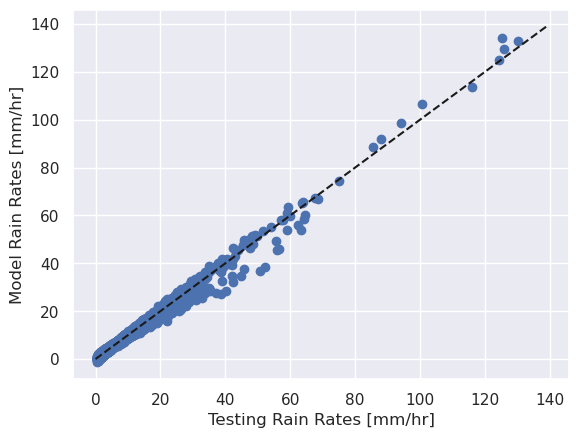

In [22]:
# set up LinearRegression model (for MLR with six inputs)
model = LinearRegression(fit_intercept=True)

# fit the model on training data
model.fit(x_train.to_numpy(), y_train.to_numpy())

# evaluate the model on the second set of data
y_model = model.predict(x_test.to_numpy())
plt.scatter(y_test, y_model)
plt.plot(range(140), range(140), 'k--')
plt.xlabel('Testing Rain Rates [mm/hr]')
plt.ylabel('Model Rain Rates [mm/hr]')

# check accuracy of testing data (R^2 and RMSE)
print('MLR R^2:', str(model.score(x_test.to_numpy(), y_test.to_numpy())))
print('MLR RMSE:', str(root_mean_squared_error(y_test.to_numpy(), y_model)))

Baseline R^2: 0.3023229070437504
Baseline RMSE: 7.157590840042378


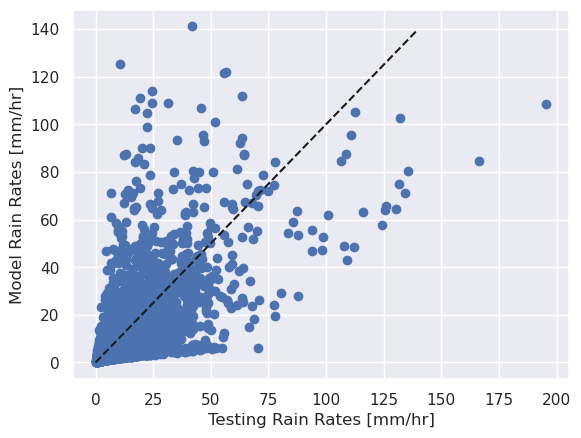

In [23]:
# empirical baseline model for R using formula Z=200R^1.6
df['R_baseline'] = (df['Z'] / 200)**(5/8)
# plot of baseline model vs actual R values 
plt.scatter(df['R (mm/hr)'], df['R_baseline'])
plt.plot(range(140), range(140), 'k--')
plt.xlabel('Testing Rain Rates [mm/hr]')
plt.ylabel('Model Rain Rates [mm/hr]')

# check accuracy of testing data (R^2 and RMSE)
print('Baseline R^2:', str(r2_score(df['R (mm/hr)'].to_numpy(), df['R_baseline'].to_numpy())))
print('Baseline RMSE:', str(root_mean_squared_error(df['R (mm/hr)'].to_numpy(), df['R_baseline'].to_numpy())))

#### 3. Repeat 1 doing a grid search over polynomial orders, using a grid search over orders 0-9, and use cross-validation of 7 folds. For the best polynomial model in terms of $R^2$, does it outperform the baseline and the linear regression model in terms of $R^2$ and root mean square error?

In [23]:
# set up parameter grid for running many polynomial models
param_grid = {'polynomialfeatures__degree': np.arange(9+1),
              'linearregression__fit_intercept': [True, False]}
# set up grid search for polynomials with 7-fold cross validation
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
# find best R^2 score model to training data
grid.fit(x_train.to_numpy(), y_train.to_numpy())

# print best parameters
print(grid.best_params_)
# get best model and plot results
model = grid.best_estimator_

{'linearregression__fit_intercept': True, 'polynomialfeatures__degree': np.int64(8)}


Best Polynomial R^2: 0.9999304180929274
Best Polynomial RMSE: 0.06973927398603211


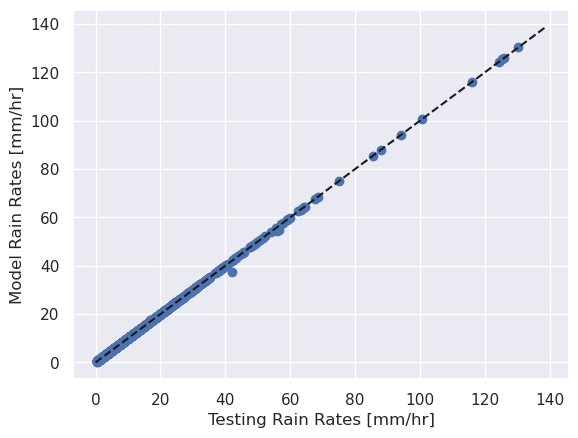

In [24]:
'''plt.scatter(y_test, y_model_rfr.predict(x_test))
plt.ylabel('Model R [mm/hr]')
plt.xlabel('Testing R [mm/hr]')'''

# evaluate the model on the second set of data
y_model = model.predict(x_test.to_numpy())
plt.scatter(y_test, y_model)
plt.plot(range(140), range(140), 'k--')
plt.xlabel('Testing Rain Rates [mm/hr]')
plt.ylabel('Model Rain Rates [mm/hr]')

# check accuracy of testing data (R^2 and RMSE)
print('Best Polynomial R^2:', str(model.score(x_test.to_numpy(), y_test.to_numpy())))
print('Best Polynomial RMSE:', str(root_mean_squared_error(y_test.to_numpy(), y_model)))

#### The best polynomial model was the 8th order with a fitted y-intercept. Yes, the 8th-order polynomial model very much outperforms the previous baseline and MLR models with a $R^2$ of 0.999 and RMSE of 0.07 mm/hr.

#### 4. Repeat 1 with a Random Forest Regressor, and perform a grid_search on the following parameters: 
```python
param_grid = {
 "bootstrap": [True, False],
 "max_depth": [10, 100],
 "max_features": ["sqrt", 1.0],  
 "min_samples_leaf": [1, 4],
 "min_samples_split": [2, 10],
 "n_estimators": [200, 1000]}
```

In [37]:
param_grid = {
    "bootstrap": [True, False],
    "max_depth": [10, 100],
    "max_features": ["sqrt", 1.0],  
    "min_samples_leaf": [1, 4],
    "min_samples_split": [2, 10],
    "n_estimators": [200, 1000]}

In [38]:
from sklearn.ensemble import RandomForestRegressor

# set up grid search for RandomForestRegressor params with 7-fold cross validation
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=7)
# find best R^2 score model to training data
grid.fit(x_train.to_numpy(), y_train.to_numpy())

# print best parameters
print(grid.best_params_)
# get best model 
y_model_rfr = grid.best_estimator_

{'bootstrap': True, 'max_depth': 100, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Best Random Forest Regressor R^2: 0.9999304180929274
Best Random Forest Regressor RMSE: 1.7490799491927134


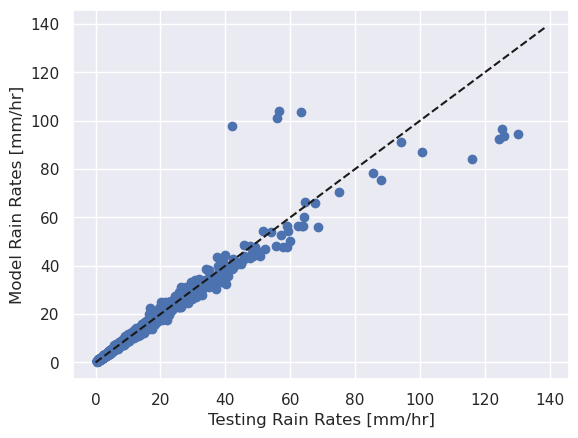

In [39]:
# evaluate the model on the second set of data
y_model = y_model_rfr.predict(x_test.to_numpy())
plt.scatter(y_test, y_model)
plt.plot(range(140), range(140), 'k--')
plt.xlabel('Testing Rain Rates [mm/hr]')
plt.ylabel('Model Rain Rates [mm/hr]')

# check accuracy of testing data (R^2 and RMSE)
print('Best Random Forest Regressor R^2:', str(model.score(x_test.to_numpy(), y_test.to_numpy())))
print('Best Random Forest Regressor RMSE:', str(root_mean_squared_error(y_test.to_numpy(), y_model)))

#### The Random Forest Regressor best model achieved essentially the same $R^2$ but a much worse RMSE compared to the best polynomial (8th-order) model. The resultant plot for the comparison of the test and model-fitted rain rates indicate that the RFR model doesn't work well for the rarer high rain rates ($\geq$ 60 mm/hr).